# Exploratory Data Analysis of Coursera Dataset

## 1. Goal of the analysis

### 1.1 The goal of this analysis is to uncover valuable insights into the factors that influence course success within our dataset. By examining various features such as enrollments, difficulty levels, certificate types, and course ratings, we aim to understand the dynamics of course popularity and engagement.

### 1.2 This EDA will focus on several key objectives:

- **Understanding the course popularity and engagement**: we will identify trends in course popularity by enrolments and frequency of different course levels;
- **Evaluate the course ratings**: we will explore how course difficulty can influence the average ratings;
- **Analyzing certificate types**: by examining the distribution of various certificate types, we can identify which courses are most in demand among learners;
- **Difficulty level insights**: we will examine the distribution of difficulty levels and how they impact the popularity.

Ultimately, this analysis will serve as a valuable resource in identifying the key elements that contribute to a successful course.

### 1.3 First, we import the main libraries and create a consistent visual colormap we will use for the analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from src.utilities import find_outliers, add_labels

In [2]:
pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.figsize'] = (10, 6)
colors=["#B68F40", "#30011E", "#348AA7", "#545454", "#DDFFF7"]
sns.set_theme(style="white")
sns.set_palette(sns.color_palette(colors))
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#B68F40","#DDFFF7","#30011E"], N=256)

## 2. Data Cleaning

### 2.1 Now, let's import the dataset and check what we're working with

In [3]:
df = pd.read_csv("coursera_data.csv")
df.head()

,Unnamed: 0,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
0,134,(ISC)² Systems Security Certified Practitioner (SSCP),(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
1,743,A Crash Course in Causality: Inferring Causal Effects from Observational Data,University of Pennsylvania,COURSE,4.7,Intermediate,17k
2,874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
3,413,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
4,635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


It seems like there's just a few features we are working with - this will make our analysis more simple for now.

### 2.2 We clean the dataset by dropping the "**Unnamed**" column, changing the student enrollment values to full numbers for future mathematical comparisons and renaming columns for easier visualization.

In [4]:
df = (df.drop("Unnamed: 0", axis=1)
      .assign(course_students_enrolled = lambda x: x["course_students_enrolled"].apply(
          lambda value: int(float(value.replace("k","")) * 1e3) if "k" in value else int(float(value.replace("m","")) * 1e6)
        ))
      .rename(columns={
          "course_title":"title",
          "course_organization":"organization",
          "course_Certificate_type":"certificate type",
          "course_rating":"rating",
          "course_difficulty":"difficulty",
          "course_students_enrolled":"students"
      })
      )
df.head()

,title,organization,certificate type,rating,difficulty,students
0,(ISC)² Systems Security Certified Practitioner (SSCP),(ISC)²,SPECIALIZATION,4.7,Beginner,5300
1,A Crash Course in Causality: Inferring Causal Effects from Observational Data,University of Pennsylvania,COURSE,4.7,Intermediate,17000
2,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130000
3,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91000
4,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320000


### 2.3 We check whether there are any missing values in the dataset

In [5]:
zeroes = (df == 0).sum()
empty_strings = (df.replace(r"^\s*$", "", regex=True) == "").sum()
nas = df.isna().sum()
combined_counts = pd.DataFrame({
    "Zeroes": zeroes,
    "Empty Strings": empty_strings,
    "NaN": nas
    })
combined_counts

,Zeroes,Empty Strings,NaN
title,0,0,0
organization,0,0,0
certificate type,0,0,0
rating,0,0,0
difficulty,0,0,0
students,0,0,0


It seems like there are none, great!

### 2.4 We check for any duplicate values

In [6]:
print(df.duplicated().sum())
print(df.T.duplicated().sum())
print(df["title"].duplicated().sum())

0
0
3


It seems like we have 3 identically named courses. Let's inspect them.

In [7]:
df[df["title"].duplicated(keep=False)]

,title,organization,certificate type,rating,difficulty,students
224,Developing Your Musicianship,Berklee College of Music,COURSE,4.8,Mixed,41000
225,Developing Your Musicianship,Berklee College of Music,SPECIALIZATION,4.8,Beginner,54000
563,Machine Learning,University of Washington,SPECIALIZATION,4.6,Intermediate,290000
564,Machine Learning,Stanford University,COURSE,4.9,Mixed,3200000
582,Marketing Digital,Universidade de São Paulo,COURSE,4.8,Beginner,81000
583,Marketing Digital,Universidad Austral,SPECIALIZATION,4.7,Beginner,39000


We can see that Berklee College of Music provides 2 course types for the same skill, one being a short course, the other being a full-fledged specialization course. As for Machine Learning and Marketing Digital courses, it seems like different organizations are providing course for these topics, implying that these specific skillsets might be in high demand.

### 2.5 How many observations do we have in total?

In [8]:
print(f"There are a total of {len(df)} observations.")

There are a total of 891 observations.


### 2.6 Let's split our features into numerical and categorical

In [9]:
numeric = [feature for feature in df if df[feature].dtype in ["int64","float64"]]
categorical = [feature for feature in df if df[feature].dtype not in ["int64","float64"]]
print(numeric)
print(categorical)

['rating', 'students']
['title', 'organization', 'certificate type', 'difficulty']


### 2.7 Let's check for outliers using the **IQR** method

In [10]:
outliers = find_outliers(df,numeric)
print(f"Outliers:\n{outliers}")

Outliers in 'rating':
59     4.2
182    4.2
331    4.2
402    4.2
413    3.3
414    4.1
445    4.2
515    4.2
522    4.0
566    3.7
569    3.9
590    4.2
598    4.0
640    4.2
676    4.2
844    4.2
873    3.9
Name: rating, dtype: float64

Outliers in 'students':
4      320000
6      350000
18     540000
27     320000
43     270000
        ...  
816    320000
850    310000
859    280000
864    260000
869    270000
Name: students, Length: 78, dtype: int64

Outliers:
     rating  students
59      4.2      6600
182     4.2    140000
331     4.2     27000
402     4.2      7400
413     3.3    140000
..      ...       ...
816     4.8    320000
850     4.8    310000
859     4.7    280000
864     4.7    260000
869     4.7    270000

[95 rows x 2 columns]


We can see that there are quite a few outliers. To inspect each feature's outliers to see if any of them are random errors/anomalies, or if they're all legitimate values, let's also look at some statistical summary for these features.

In [11]:
df[numeric].agg(["min","median","max","std"])

,rating,students
min,3.300000,1.500000e+03
median,4.700000,4.200000e+04
max,5.000000,3.200000e+06
std,0.162225,1.819365e+05


While we do have outliers in the "rating" and "students" columns, all of them seem to fall within reasonable ranges of realistic features. Having low-rated courses as outliers means that the majority of the courses are rated very highly, and since our median student count is about 42k, while the minimum is only 1.5k, most higher values will be identified as outliers. To keep the analysis accurate, we will not be removing this data, but let's explore it further right now.

## 3. Data analysis

### 3.1 Let's check the distribution of enrolled students visually

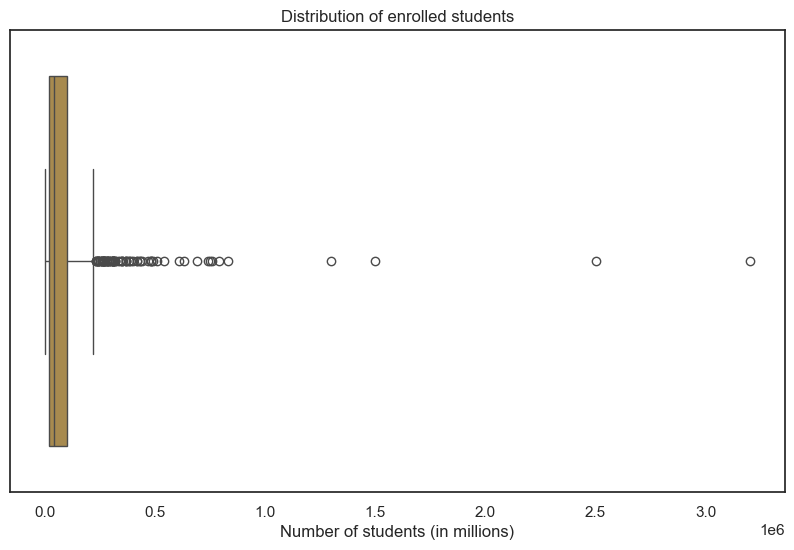

count    8.910000e+02
mean     9.055208e+04
std      1.819365e+05
min      1.500000e+03
25%      1.750000e+04
50%      4.200000e+04
75%      9.950000e+04
max      3.200000e+06
Name: students, dtype: float64

In [12]:
ax = sns.boxplot(data=df["students"], orient="h")
ax.set_title("Distribution of enrolled students")
ax.set_xlabel("Number of students (in millions)")
plt.show()
df["students"].describe()

As we saw before, the distribution is very tight on the lower side. 75% of the courses fall within less than 100k enrollments. This makes the more in-demand courses appear as strong outliers, with quite a few of them reaching values above half a million.

### 3.2 To understand the enrollment distribution better, let's visualize it after applying the **Logarithmic Scale**

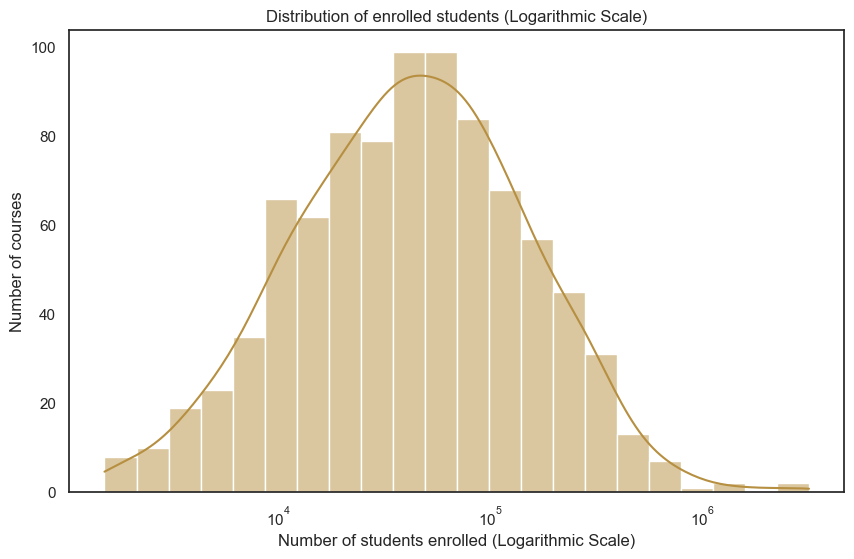

In [13]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df["students"], log_scale=True, kde=True)
ax.set_ylabel("Number of courses")
ax.set_xlabel("Number of students enrolled (Logarithmic Scale)")
ax.set_title("Distribution of enrolled students (Logarithmic Scale)")
plt.show()

Now we see a more normal, bell-shaped distribution. We can see that most enrollments are between 10,000 and 100,000, with the values rapidly dropping on both sides. The **Logarithmic Scale** transformation helped us better illustrate the enrollment distribution.

We must note that while we see the amount of enrolled students for each course, we do **not** know the exact status of them. While the courses with the most enrollments may be popular, the number of students that have actually finished the course may be very slim. Therefore, to make more accurate analysis and predictions, we would benefit from having the number of students that have completed each course in our dataset.

### 3.3 Let's analyze the rating distribution based on the course's difficulty

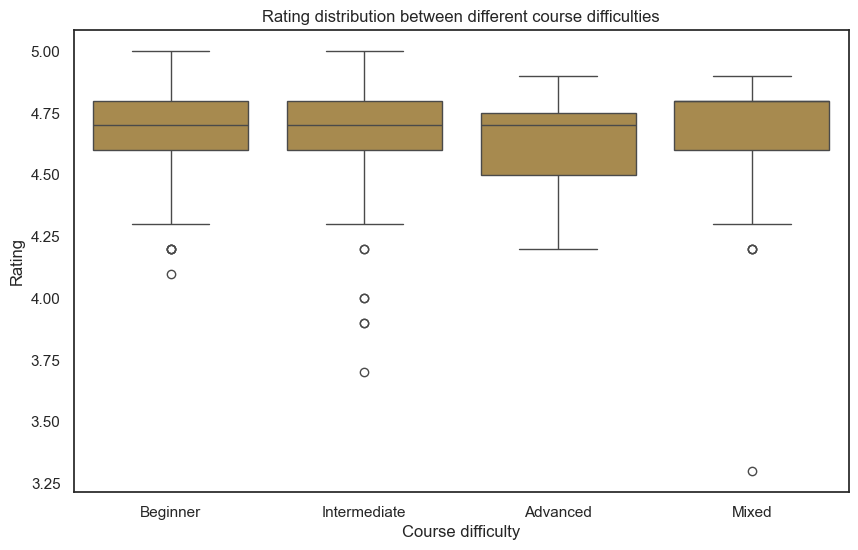

,min,median,max
difficulty,,,
Beginner,4.1,4.7,5.0
Intermediate,3.7,4.7,5.0
Advanced,4.2,4.7,4.9
Mixed,3.3,4.8,4.9


In [14]:
difficulty_order = ["Beginner", "Intermediate", "Advanced", "Mixed"]

ax = sns.boxplot(data=df, x="difficulty", y="rating", order=difficulty_order)
ax.set_title("Rating distribution between different course difficulties")
ax.set_ylabel("Rating")
ax.set_xlabel("Course difficulty")
plt.show()

df.groupby("difficulty")["rating"].agg(["min","median","max"]).reindex(difficulty_order)

As we saw before from the outliers, ratings of 4.2 and below are far from the median, since most courses are rated very highly. It seems like the beginner and advanced difficulty courses have the best rating overall, while quite a few courses in the intermediate difficulty tend to receive ratings in the lower outlier range.

### 3.4 What are the highest and lowest rated courses?

In [15]:
highest_rated_courses = df[df["rating"] == 5]
lowest_rated_courses = df[df["rating"] < 3.8]
courses_of_interest = pd.concat([highest_rated_courses, lowest_rated_courses])
courses_of_interest.head()

,title,organization,certificate type,rating,difficulty,students
251,El Abogado del Futuro: Legaltech y la Transformación Digital del Derecho,Universidad Austral,COURSE,5.0,Beginner,1500
432,Infectious Disease Modelling,Imperial College London,SPECIALIZATION,5.0,Intermediate,1600
413,How To Create a Website in a Weekend! (Project-Centered Course),The State University of New York,COURSE,3.3,Mixed,140000
566,Machine Learning and Reinforcement Learning in Finance,New York University,SPECIALIZATION,3.7,Intermediate,29000


It seems like the courses with a maximum rating of 5 are very niche, as they have the lowest amount of students. However, while they may be niche, the rating indicates good quality of the course.

For the lowest rated courses, it seems like the course quality may be poor, as the topics themselves are in demand (web-making and machine learning skills are well needed these days).

### 3.5 How many unique organizations are there?

In [16]:
print(f"There are a total of {len(df['organization'].unique())} unique organizations providing courses.")

There are a total of 154 unique organizations providing courses.


### 3.6 Let's visualize the top 15 organizations by the amount of courses they provide

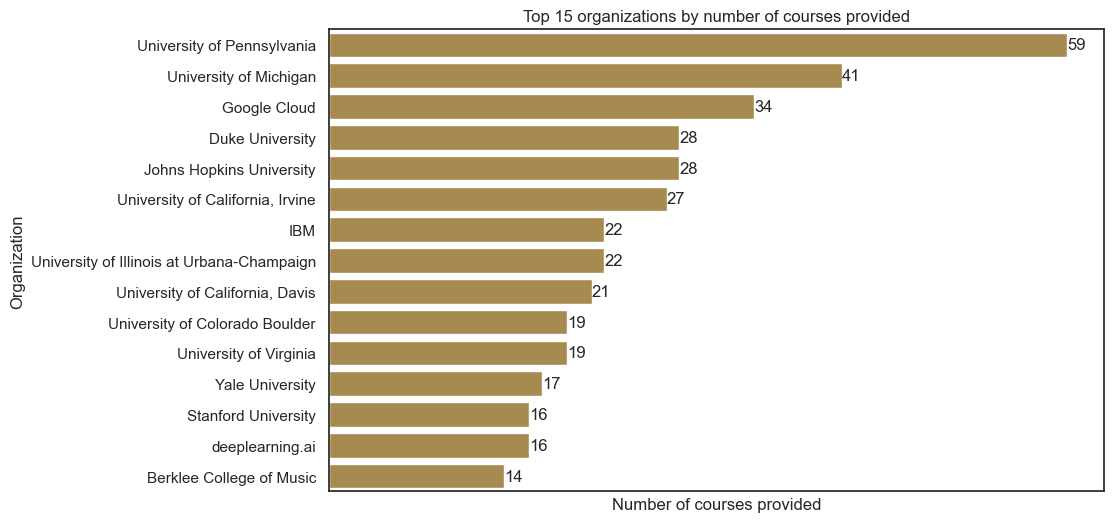

In [17]:
organization_list = (df["organization"].value_counts()
                     .reset_index()
                     .head(15))

ax = sns.barplot(data=organization_list, x="count", y="organization")
add_labels(ax, "h")
ax.set_ylabel("Organization")
ax.set_xlabel("Number of courses provided")
ax.set_title("Top 15 organizations by number of courses provided")
plt.show()

We can see that the University of Pennsylvania has the most courses by far, followed by the University of Michigan. There are still quite a lot of organizations with at least 10 courses provided, but they are not as prominent in quantity. However, high quantity of courses does not imply high quality. We would need to inspect the top providers by each of their courses to better determine the quality of these organizations.

### 3.7 For comparison, let's visualize the top 15 organizations by their average ratings

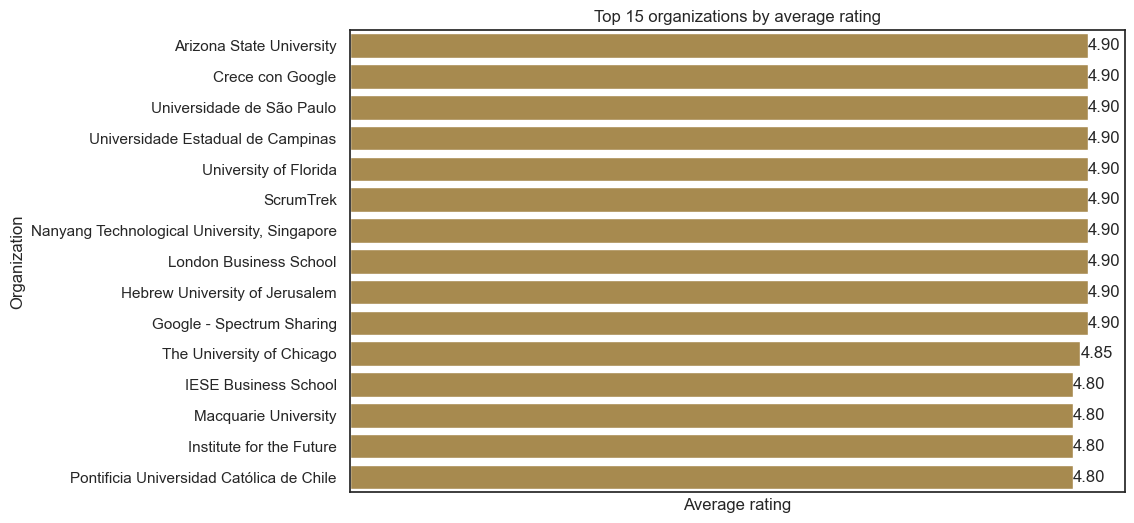

In [18]:
organization_rating = (df.groupby("organization")["rating"]
                       .median()
                       .reset_index()
                       .sort_values(by="rating", ascending=False)
                       .head(15))

ax = sns.barplot(data=organization_rating, x="rating", y="organization")
add_labels(ax,"h")
ax.set_ylabel("Organization")
ax.set_xlabel("Average rating")
ax.set_title("Top 15 organizations by average rating")
plt.show()

We see that the previously seen frontrunners in the number of courses don't really appear in the top courses by average rating. This solidifies our hypothesis that having many courses does not necessarily mean they are all of good quality.

### 3.8 Let's see the distribution of different certificate types by course difficulty

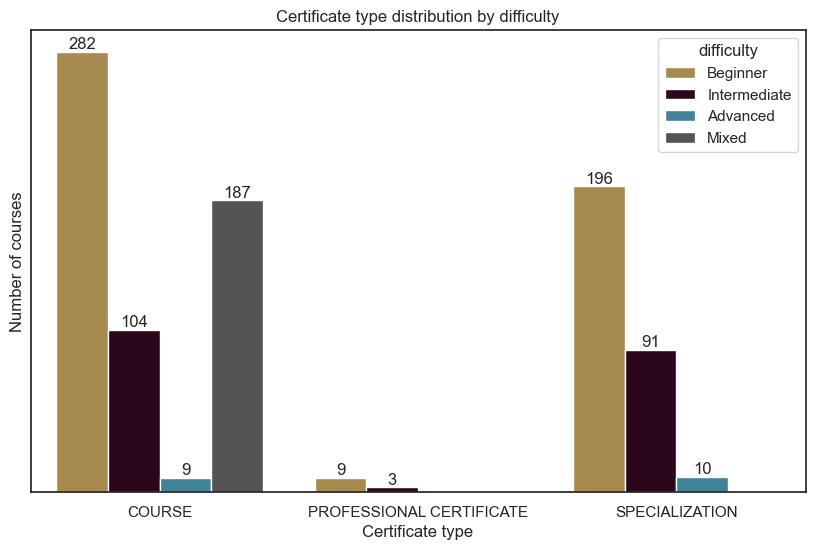

In [19]:
certificate_difficulty_data = df.groupby(['certificate type', 'difficulty']).size().reset_index(name="count")

ax = sns.barplot(data=certificate_difficulty_data, x="certificate type", y="count", hue="difficulty", hue_order=difficulty_order)
add_labels(ax)
ax.set_ylabel("Number of courses")
ax.set_xlabel("Certificate type")
ax.set_title("Certificate type distribution by difficulty")
plt.show()

We can see that the professional certificate courses are mainly of beginner difficulty, with a couple of intermediate difficulty courses. For normal and specialization courses, the beginner difficulty is by far the most occuring one, implying that most students on Coursera may want to start learning new skills. While the intermediate difficulty is still prominent, there are barely any advanced courses provided, suggesting that not too many organizations may have the required variety of high-level skills that would work with Coursera's platform.

### 3.9 Let's visualize the ratings of courses based on the number of students

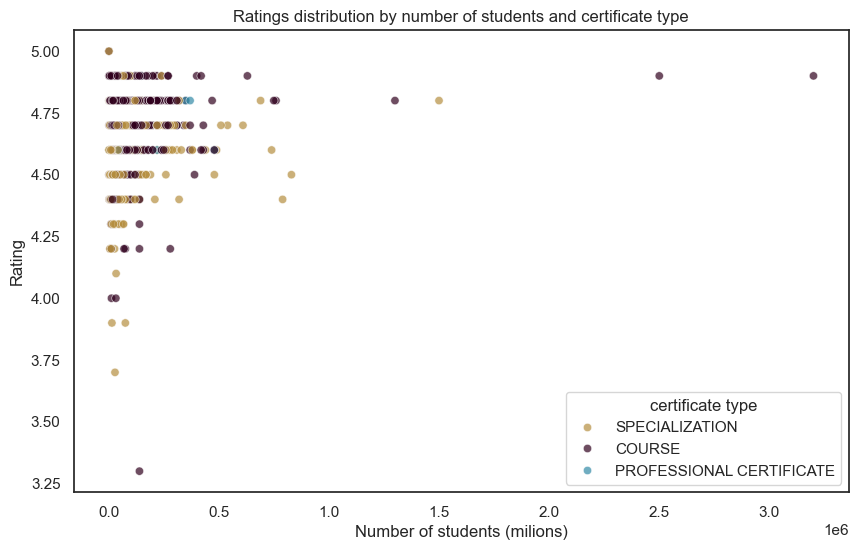

In [20]:
ax = sns.scatterplot(data=df, x="students", y="rating", hue="certificate type", alpha=0.7)
ax.set_ylabel("Rating")
ax.set_xlabel("Number of students (milions)")
ax.set_title("Ratings distribution by number of students and certificate type")
plt.show()

What's quite impressive is that the courses with the most students all have high ratings (4.8 or above). As so many students are taking these courses, the rating must be accurate and suggest these specific courses are of a very high quality.

### 3.10 What's the most popular course?

In [21]:
most_popular_course = df.iloc[df["students"].idxmax()]

print(f'The course with the most enrolments ({most_popular_course["students"]}) is {most_popular_course["title"]}, ran by {most_popular_course["organization"]}, with a rating of {most_popular_course["rating"]}.')

The course with the most enrolments (3200000) is Machine Learning, ran by Stanford University, with a rating of 4.9.


Machine Learning is a skill in high demand currently, and a rating of 4.9 suggests good quality of the course. These factors indicate that the course is well-regarded.

### 3.11 What's the least popular course?

In [22]:
least_popular_course = df.iloc[df["students"].idxmin()]

print(f'The course with the least enrolments ({least_popular_course["students"]}) is {least_popular_course["title"]}, ran by {least_popular_course["organization"]}, with a rating of {least_popular_course["rating"]}.')

The course with the least enrolments (1500) is El Abogado del Futuro: Legaltech y la Transformación Digital del Derecho, ran by Universidad Austral, with a rating of 5.0.


As we noticed previously, the least popular course has the maximum rating of 5, and is also quite niche. It seems to be a Spanish course on Law, which can lead to possible further analization on the skill interest in Spain.

### 3.12 Let's check whether there is any correlation between the course rating and students enrolled

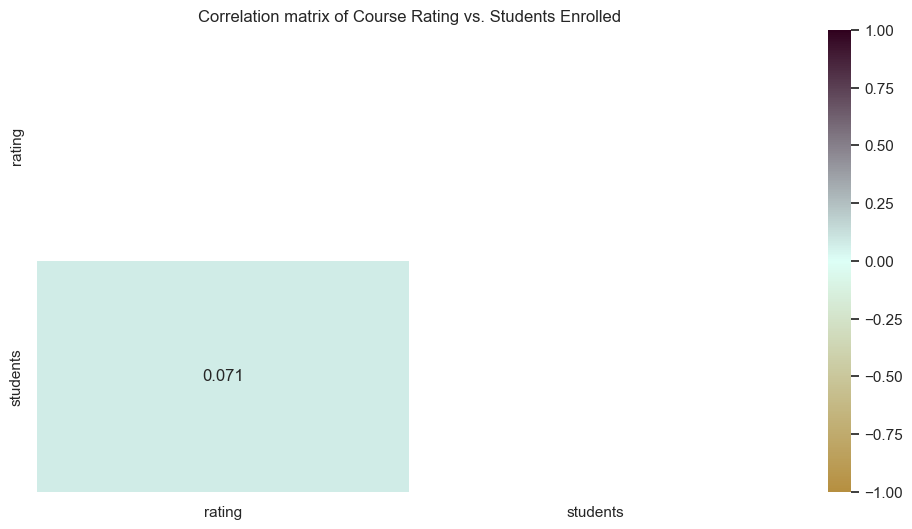

In [23]:
correlation = df[numeric].corr()
plt.figure(figsize=(12, 6))
mask = np.triu(np.ones_like(correlation, dtype=bool))
ax = sns.heatmap(correlation, cmap=cmap, annot=True, mask=mask, vmax=1, vmin=-1)
ax.set_title("Correlation matrix of Course Rating vs. Students Enrolled")
plt.show()

It seems like there is no correlation, which is what we also noticed from our previous visualizations - some courses with the highest ratings have the least amount of students, while there are also courses with subpar ratings that have over 500k students.

## 4. Conclusion

After exploring and analyzing our dataset, we have come to these conclusions:

- **Course popularity and engagement**: *Beginner* and *Intermediate* difficulties take up the majority of the observations, with only a few *Advanced* courses;
- **Course ratings**: *Beginner* and *Advanced* courses generally have more stable ratings. There also seems to be no correlation between ratings and the number of students enrolled;
- **Certificate types**: the *Course* type is in the lead, followed by substantial *Specialization* amount and very few *Professional Certificate* courses;
- **Difficulty level**: the vast majority of courses are *Beginner* level, with *Mixed* and *Intermediate* difficulty being on the same level. However, as with *Professional Certificate* courses, the *Advanced* level courses are very sparse.

## 5. Future improvements

- Assign numeric values to **difficulties** of courses to do some more visual comparison (such as correlations);
- Check the relationship between enrolled students and course's **difficulty**;
- Analyze courses by number of students that have actually finished the course (expansion on dataset needed).